In [1]:
import os

In [2]:
# Setting toolkit folder as working directory

os.chdir(r'C:\Users\prvsa\Downloads\sentiment analysis')

In [3]:
print(os.listdir())

['a1_IMDB_Dataset.csv', 'a2_glove.6B.100d.txt', 'a3_IMDb_Unseen_Reviews.csv', 'b_SentimentAnalysis_with_NeuralNetwork.ipynb', 'c1_lstm_model_acc_0.861.h5', 'c2_IMDb_Unseen_Predictions.csv']


In [4]:
!pip install pandas numpy nltk keras scikit-learn


In [5]:
# Importing essential libraries and functions

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array

from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

## Loading dataset

In [6]:

movie_reviews = pd.read_csv("a1_IMDB_Dataset.csv")


In [7]:
# Dataset exploration

movie_reviews.shape

(50000, 2)

In [8]:
movie_reviews.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [13]:
# Checking for missing values

movie_reviews.isnull().values.any()

False

<Axes: xlabel='sentiment', ylabel='count'>

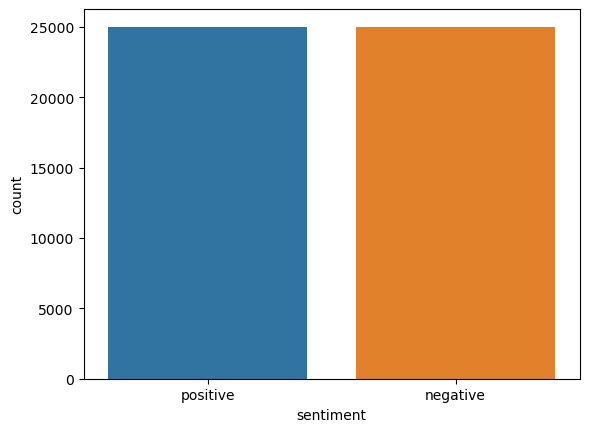

In [12]:
# observing distribution of positive / negative sentiments in dataset

import seaborn as sns
sns.countplot(x='sentiment', data=movie_reviews)

## Data Preprocessing

In [9]:
movie_reviews["review"][3]


"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

In [10]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):

    return TAG_RE.sub('', text)

In [11]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\prvsa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''

    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  
    
    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [13]:
# Calling preprocessing_text function on movie_reviews

X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [14]:
# Sample cleaned up movie review

X[3]


'basically family little boy jake thinks zombie closet parents fighting time movie slower soap opera suddenly jake decides become rambo kill zombie ok first going make film must decide thriller drama drama movie watchable parents divorcing arguing like real life jake closet totally ruins film expected see boogeyman similar movie instead watched drama meaningless thriller spots well playing parents descent dialogs shots jake ignore '

In [15]:
# Converting sentiment labels to 0 & 1

y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# The train set will be used to train our deep learning models
# while test set will be used to evaluate how well our model performs

## Preparing embedding layer

In [17]:

# fit_on_text trains the tokenizer
# texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)


In [18]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length 

92394

In [19]:
# Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [20]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('a2_glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [21]:
# Creating Embedding Matrix having 100 columns
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [22]:
embedding_matrix.shape

(92394, 100)

# Model Training 

In [ ]:
#Simple Neural Network

In [23]:
from keras.layers import LSTM
from keras.layers import Dense

In [24]:
# Neural Network architecture

snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

snn_model.add(embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

In [25]:
# Model compiling

snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(snn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9239400   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 1)                 10001     
                                                                 
Total params: 9249401 (35.28 MB)
Trainable params: 10001 (39.07 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None


In [28]:
# Model training

snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 2s 5ms/step - loss: 0.5616 - acc: 0.7108 - val_loss: 0.5385 - val_acc: 0.7434
Epoch 2/6
250/250 [==============================] - 1s 5ms/step - loss: 0.4514 - acc: 0.7947 - val_loss: 0.4938 - val_acc: 0.7650
Epoch 3/6
250/250 [==============================] - 1s 5ms/step - loss: 0.4135 - acc: 0.8164 - val_loss: 0.5028 - val_acc: 0.7630
Epoch 4/6
250/250 [==============================] - 1s 4ms/step - loss: 0.3895 - acc: 0.8273 - val_loss: 0.5101 - val_acc: 0.7601
Epoch 5/6
250/250 [==============================] - 1s 4ms/step - loss: 0.3763 - acc: 0.8374 - val_loss: 0.5256 - val_acc: 0.7577
Epoch 6/6
250/250 [==============================] - 1s 5ms/step - loss: 0.3646 - acc: 0.8409 - val_loss: 0.5369 - val_acc: 0.7548


In [29]:
# Predictions on the Test Set

score = snn_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 1s 2ms/step - loss: 0.5599 - acc: 0.7477


In [31]:
# Model Performance

print("Test Accuracy:", score[1])


Test Accuracy: 0.7476999759674072


## Recurrent Neural Network (LSTM)

In [32]:
from keras.layers import LSTM
from keras.layers import Dense


In [33]:
# Neural Network architecture

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

In [34]:
# Model compiling

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9356777 (35.69 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None


In [35]:
# Model Training

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 37s 138ms/step - loss: 0.5147 - acc: 0.7501 - val_loss: 0.4452 - val_acc: 0.8048
Epoch 2/6
250/250 [==============================] - 33s 133ms/step - loss: 0.4142 - acc: 0.8142 - val_loss: 0.4003 - val_acc: 0.8301
Epoch 3/6
250/250 [==============================] - 34s 138ms/step - loss: 0.3677 - acc: 0.8388 - val_loss: 0.4027 - val_acc: 0.8240
Epoch 4/6
250/250 [==============================] - 36s 142ms/step - loss: 0.3455 - acc: 0.8544 - val_loss: 0.3301 - val_acc: 0.8593
Epoch 5/6
250/250 [==============================] - 39s 155ms/step - loss: 0.3209 - acc: 0.8659 - val_loss: 0.3256 - val_acc: 0.8596
Epoch 6/6
250/250 [==============================] - 38s 152ms/step - loss: 0.3036 - acc: 0.8732 - val_loss: 0.3299 - val_acc: 0.8620


In [36]:
# Predictions on the Test Set

score = lstm_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 8s 26ms/step - loss: 0.3303 - acc: 0.8643


In [38]:
# Model Performance
print("Test Accuracy:", score[1])

Test Accuracy: 0.864300012588501


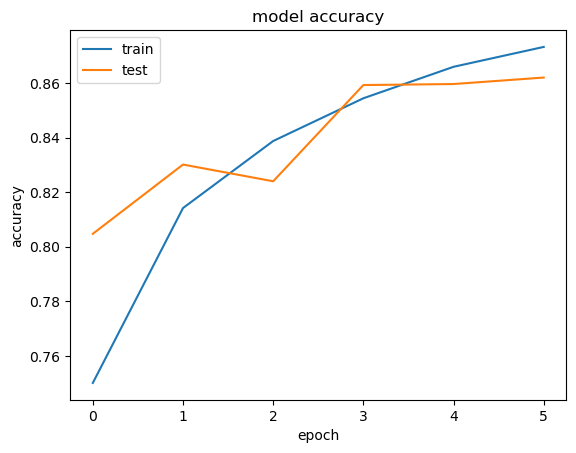

In [40]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()



In [41]:
# Saving the model as a h5 file for possible use later

lstm_model.save(f"./c1_lstm_model_acc_{round(score[1], 3)}.h5", save_format='h5')

C:\Users\prvsa\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#CNN

In [52]:
from keras.layers import Conv1D

In [53]:
# Neural Network architecture

cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [54]:
# Model compiling

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9303657 (35.49 MB)
Trainable params: 64257 (251.00 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None


In [55]:
# Model training

cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 10s 39ms/step - loss: 0.4921 - acc: 0.7621 - val_loss: 0.3901 - val_acc: 0.8326
Epoch 2/6
250/250 [==============================] - 9s 37ms/step - loss: 0.3491 - acc: 0.8495 - val_loss: 0.3652 - val_acc: 0.8430
Epoch 3/6
250/250 [==============================] - 12s 46ms/step - loss: 0.2959 - acc: 0.8792 - val_loss: 0.3419 - val_acc: 0.8520
Epoch 4/6
250/250 [==============================] - 13s 51ms/step - loss: 0.2469 - acc: 0.9060 - val_loss: 0.3402 - val_acc: 0.8524
Epoch 5/6
250/250 [==============================] - 11s 44ms/step - loss: 0.2098 - acc: 0.9262 - val_loss: 0.3276 - val_acc: 0.8609
Epoch 6/6
250/250 [==============================] - 10s 40ms/step - loss: 0.1714 - acc: 0.9483 - val_loss: 0.3365 - val_acc: 0.8583


In [56]:
# Predictions on the Test Set

score = cnn_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 2s 6ms/step - loss: 0.3407 - acc: 0.8531


In [58]:
# Model Performance

print("Test Accuracy:", score[1])

Test Accuracy: 0.8531000018119812


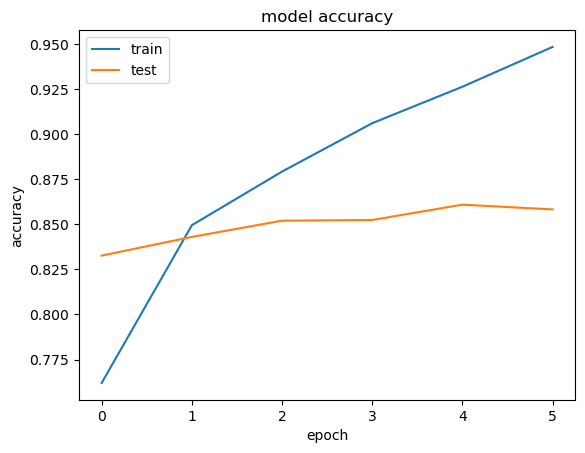

In [59]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()


# Making Predictions on Live IMDb data

In [46]:
# Load sample IMDb reviews csv, having ~6 movie reviews, along with their IMDb rating

sample_reviews = pd.read_csv("a3_IMDb_Unseen_Reviews.csv")

#sample_reviews["Review Text"][0]
sample_reviews.head(6)

,Unnamed: 0,Movie,Review Text,IMDb Rating
0,0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9
1,1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10
2,2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3
3,3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1
4,4,Eternals,Amazing visuals and philosophical concepts!\n\...,10
5,5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3


In [47]:
# Preprocess review text with earlier defined preprocess_text function

unseen_reviews = sample_reviews['Review Text']

unseen_processed = []
for review in unseen_reviews:
  review = preprocess_text(review)
  unseen_processed.append(review)

In [48]:
# Tokenising instance with earlier trained tokeniser
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)

# Pooling instance to have maxlength of 100 tokens
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)

In [49]:
# Passing tokenised instance to the LSTM model for predictions
unseen_sentiments = lstm_model.predict(unseen_padded)

unseen_sentiments

1/1 [==============================] - 1s 611ms/step


array([[0.8217473 ],
       [0.98515975],
       [0.17063925],
       [0.32266077],
       [0.9263559 ],
       [0.05607135]], dtype=float32)

In [50]:
# Writing model output file back to Google Drive

sample_reviews['Predicted Sentiments'] = np.round(unseen_sentiments*10,1)

df_prediction_sentiments = pd.DataFrame(sample_reviews['Predicted Sentiments'], columns = ['Predicted Sentiments'])
df_movie                 = pd.DataFrame(sample_reviews['Movie'], columns = ['Movie'])
df_review_text           = pd.DataFrame(sample_reviews['Review Text'], columns = ['Review Text'])
df_imdb_rating           = pd.DataFrame(sample_reviews['IMDb Rating'], columns = ['IMDb Rating'])


dfx=pd.concat([df_movie, df_review_text, df_imdb_rating, df_prediction_sentiments], axis=1)

dfx.to_csv("./c2_IMDb_Unseen_Predictions.csv", sep=',', encoding='UTF-8')

dfx.head(6)

,Movie,Review Text,IMDb Rating,Predicted Sentiments
0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9,8.2
1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10,9.9
2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3,1.7
3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1,3.2
4,Eternals,Amazing visuals and philosophical concepts!\n\...,10,9.3
5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3,0.6
